In [1]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [1]:
path = "/content/drive/My Drive/practicum-data"

In [2]:
from termcolor import colored

In [3]:
import sys
sys.path.insert(0,'/content/drive/My Drive/Colab Notebooks')

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.datasets import make_multilabel_classification
from keras.models import Sequential
from keras.layers import Dense, Bidirectional, LSTM, Dropout, BatchNormalization, Flatten
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, multilabel_confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf 
#import utilities #
from Util import Util
import os

In [6]:
smiles_df = pd.read_csv(os.path.join(path, 'smiles_converted.csv'))
smiles_df = smiles_df.rename(columns={'Name':'Molecule ChEMBL ID'})

In [7]:
training_data = pd.read_csv(os.path.join(path, 'Training-Data.csv'))

In [10]:
smiles_df.head()

,Molecule ChEMBL ID,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,CHEMBL3823268,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,CHEMBL463931,1,1,1,1,0,0,0,0,0,1,1,1,1,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,CHEMBL3937351,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,CHEMBL476259,1,1,1,1,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,CHEMBL514873,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
all_data = pd.merge(training_data, smiles_df, on='Molecule ChEMBL ID', how='outer')
all_data = all_data.drop(columns=['Smiles', "Molecule ChEMBL ID"])
all_data.head()

,CHEMBL614725,CHEMBL1957,CHEMBL2842,CHEMBL203,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,0,1,0,0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,1,1,1,1,0,0,0,0,0,1,1,1,1,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,1,1,1,1,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Prepare the dataset

In [19]:
util_fn = Util(all_data, {'CHEMBL614725', 'CHEMBL1957', 'CHEMBL2842', 'CHEMBL203'})
target_ids = ['CHEMBL614725', 'CHEMBL1957', 'CHEMBL2842', 'CHEMBL203']

In [22]:
def get_dataset():
    y = all_data[target_ids]
    X = all_data.drop(columns=target_ids)
    return X, y

In [25]:
# load dataset
X, y = get_dataset()
n_inputs, n_outputs = X.shape[1], y.shape[1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# LSTM Model

In [184]:
from tensorflow.keras import regularizers

In [237]:
def lstm_model(n_features, n_outputs):
    model = Sequential()
    model.add(Bidirectional(LSTM(1000, activation='relu', return_sequences=True), input_shape=(1, n_features)))
    model.add(Bidirectional(LSTM(500, activation='relu', return_sequences=True)))
    model.add(Bidirectional(LSTM(500, activation='relu', return_sequences=True)))
    model.add(Flatten())
    model.add(Dropout(0.1))
    model.add(Dense(128))
    model.add(Dense(n_outputs, activation="sigmoid"))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC'])
    print(model.summary())
    return model

## Prepare data for lstm model

In [238]:
n_samples = len(X_train)
n_features = n_inputs
train_X = X_train.to_numpy().reshape(n_samples, 1, n_features)
train_y = y_train.to_numpy()

In [239]:
model = lstm_model(n_inputs, n_outputs)

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_35 (Bidirectio (None, 1, 2000)           15056000  
_________________________________________________________________
bidirectional_36 (Bidirectio (None, 1, 1000)           10004000  
_________________________________________________________________
bidirectional_37 (Bidirectio (None, 1, 1000)           6004000   
_________________________________________________________________
flatten_7 (Flatten)          (None, 1000)              0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_29 (Dense)             (None, 128)               128128    
_________________________________________________________________
dense_30 (Dense)             (None, 4)               

In [240]:
history = model.fit(train_X, train_y, epochs=100)

Epoch 1/100
136/136 [==============================] - 8s 19ms/step - loss: 0.4631 - accuracy: 0.5456 - auc: 0.7793
Epoch 2/100
136/136 [==============================] - 3s 19ms/step - loss: 0.2769 - accuracy: 0.7386 - auc: 0.9319
Epoch 3/100
136/136 [==============================] - 2s 18ms/step - loss: 0.2008 - accuracy: 0.8272 - auc: 0.9653
Epoch 4/100
136/136 [==============================] - 3s 19ms/step - loss: 0.1637 - accuracy: 0.8675 - auc: 0.9769
Epoch 5/100
136/136 [==============================] - 3s 19ms/step - loss: 0.1304 - accuracy: 0.8905 - auc: 0.9851
Epoch 6/100
136/136 [==============================] - 3s 19ms/step - loss: 0.1147 - accuracy: 0.9011 - auc: 0.9891
Epoch 7/100
136/136 [==============================] - 3s 19ms/step - loss: 0.1010 - accuracy: 0.9082 - auc: 0.9908
Epoch 8/100
136/136 [==============================] - 3s 19ms/step - loss: 0.1119 - accuracy: 0.9136 - auc: 0.9896
Epoch 9/100
136/136 [==============================] - 2s 18ms/step - lo

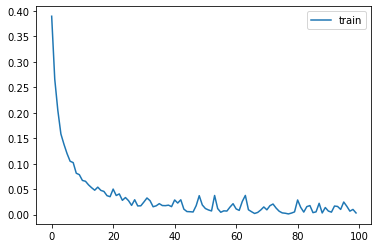

In [241]:
# plt.title('Loss Keras Model')
plt.plot(history.history['loss'], label='train')
#plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

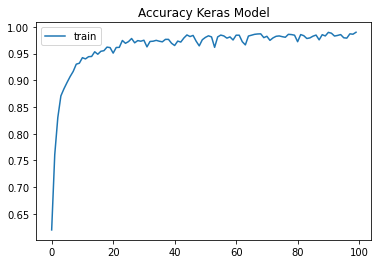

In [243]:
plt.title('Accuracy Keras Model')
plt.plot(history.history['accuracy'], label='train')
#plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

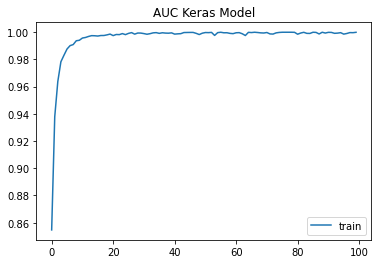

In [244]:
plt.title('AUC Keras Model')
plt.plot(history.history['auc'], label='train')
plt.legend()
plt.show()

In [245]:
n_samples_test = len(X_test)
n_features = n_inputs
test_X = X_test.to_numpy().reshape(n_samples_test, 1, n_features)

In [246]:
y_pred = model.predict(test_X)

y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0
y_pred

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [247]:
accuracy_score_val = accuracy_score(y_test, y_pred)
accuracy_score_val

0.8840846366145354

In [248]:
accuracy_score_val = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
f1_measure = 2 * ((precision * recall) / (precision + recall))
print('Calculated Accuracy score: {}, Precision: {}, Recall: {}, \n F1 measure: {} '.format(accuracy_score_val,
                                                            precision, recall, f1_measure))

Calculated Accuracy score: 0.8840846366145354, Precision: 0.9073083778966132, Recall: 0.9016829052258636, 
 F1 measure: 0.9044868947134607 


In [249]:
def get_active_targets(compounds):
    compounds_predicted = {}
    molecule_ids = training_data[training_data["Smiles"].isin(compounds)]["Molecule ChEMBL ID"].tolist()
    compounds = training_data[training_data["Smiles"].isin(compounds)]["Smiles"].tolist()
    finger_prints = smiles_df[smiles_df["Molecule ChEMBL ID"].isin(molecule_ids)]
    drop_columns =  ["Molecule ChEMBL ID"]
    finger_prints = finger_prints.drop(columns=drop_columns)
    n_samples_test = len(finger_prints)
    n_features = n_inputs
    i = 0
    for index, row in finger_prints.iterrows():
        X_new = row.to_numpy().reshape(1, 1, n_features)
        pred = model.predict(X_new)[0]
        print(pred)
        compounds_predicted[compounds[i]] = { 'targets': [], 'prob': []}
        for j in range(0, len(pred)):
            prob = pred[j]
            t = util_fn.target_abbr_from_id(target_ids[j])
            compounds_predicted[compounds[i]]['targets'].append(t)
            compounds_predicted[compounds[i]]['prob'].append(prob)
        i += 1
    
    return compounds_predicted

In [250]:
smiles = ['N#CCCCn1nc(-c2ccc(F)c(O)c2)c2c(N)ncnc21', 
          'CS(=O)(=O)N1CCN(Cc2cc3nc(-c4cccc5[nH]ncc45)nc(N4CCOCC4)c3s2)CC1',
          'Nc1ccc(-c2ccc3ncc4c(=O)[nH]c(=O)n(-c5cccc(C(F)(F)F)c5)c4c3n2)cn1',
          
             ]
finger_print = X_test.iloc[[0]]
compounds = get_active_targets(smiles)
for t in compounds:
    print(colored("Following target probabilites are predicted for Compound: \n {} \n \n".format(t), 'blue'))
    i = 0
    for target in compounds[t]['targets']:
        prob = compounds[t]['prob'][i]
        if prob >= 0.5:
            print(colored("Target {}, Probability {}% \n \n".format( target, round(prob * 100)) , 'green'))
        else:
            print(colored("Target {}, Probability {}% \n \n".format( target, round(prob * 100)) , 'red'))
        i += 1

[0.00216488 0.99951375 0.9999975  0.9962639 ]
[9.9982530e-01 1.1226877e-03 9.9998748e-01 4.0574723e-05]
[4.8483193e-06 2.3110504e-06 9.9999988e-01 9.9972719e-01]
Following target probabilites are predicted for Compound: 
 Nc1ccc(-c2ccc3ncc4c(=O)[nH]c(=O)n(-c5cccc(C(F)(F)F)c5)c4c3n2)cn1 
 

Target MIA PaCa-2, Probability 0% 
 

Target IGF-1, Probability 100% 
 

Target mTOR, Probability 100% 
 

Target EGFR-erbB1, Probability 100% 
 

Following target probabilites are predicted for Compound: 
 CS(=O)(=O)N1CCN(Cc2cc3nc(-c4cccc5[nH]ncc45)nc(N4CCOCC4)c3s2)CC1 
 

Target MIA PaCa-2, Probability 100% 
 

Target IGF-1, Probability 0% 
 

Target mTOR, Probability 100% 
 

Target EGFR-erbB1, Probability 0% 
 

Following target probabilites are predicted for Compound: 
 N#CCCCn1nc(-c2ccc(F)c(O)c2)c2c(N)ncnc21 
 

Target MIA PaCa-2, Probability 0% 
 

Target IGF-1, Probability 0% 
 

Target mTOR, Probability 100% 
 

Target EGFR-erbB1, Probability 100% 
 



In [251]:
training_data[training_data["Smiles"].isin(smiles)]


,Molecule ChEMBL ID,Smiles,CHEMBL614725,CHEMBL1957,CHEMBL2842,CHEMBL203
493,CHEMBL3903725,Nc1ccc(-c2ccc3ncc4c(=O)[nH]c(=O)n(-c5cccc(C(F)...,0,1,1,1
1452,CHEMBL521851,CS(=O)(=O)N1CCN(Cc2cc3nc(-c4cccc5[nH]ncc45)nc(...,1,0,1,0
2157,CHEMBL1242469,N#CCCCn1nc(-c2ccc(F)c(O)c2)c2c(N)ncnc21,0,0,1,1


In [252]:
cm = multilabel_confusion_matrix(y_test, y_pred)
cm

array([[[911,  24],
        [ 15, 137]],

       [[900,  21],
        [ 31, 135]],

       [[821,  15],
        [ 15, 236]],

       [[483,  44],
        [ 50, 510]]])

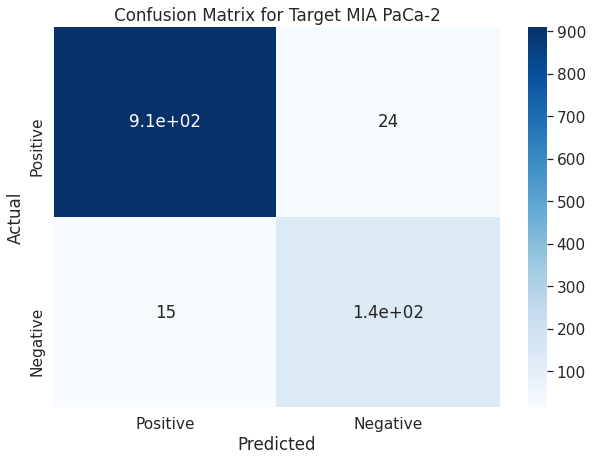

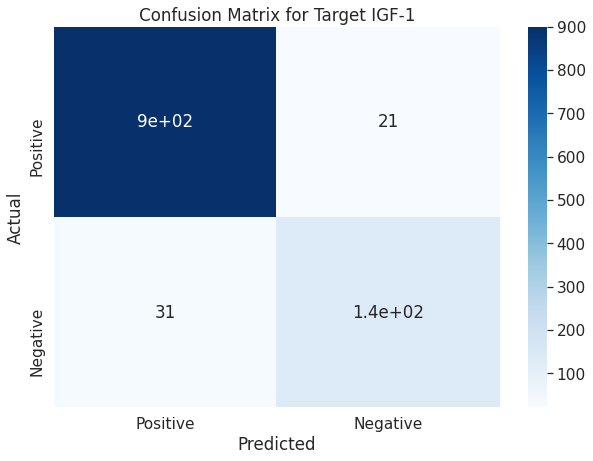

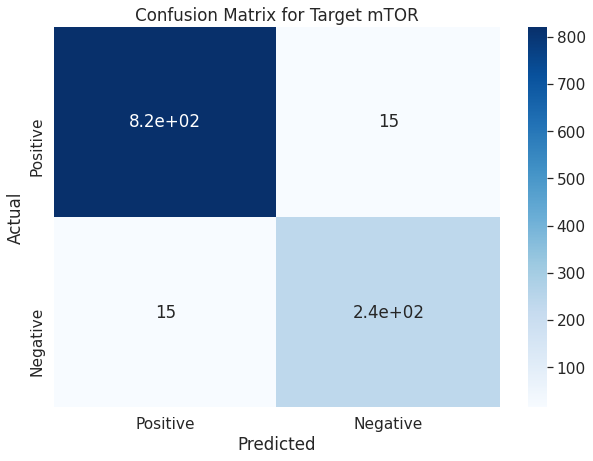

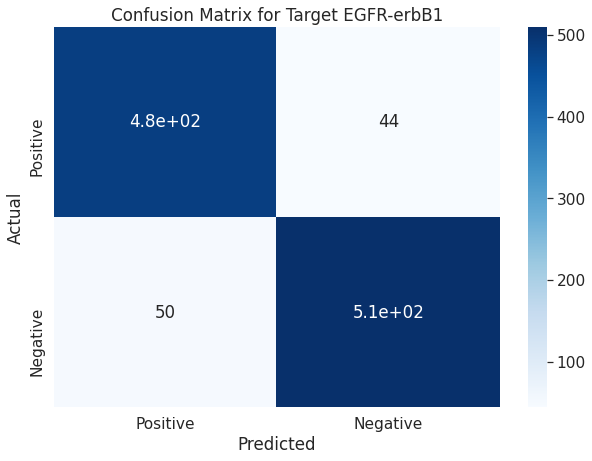

In [253]:
i = 0
for t in cm:
    sns.set(font_scale=1.4)#for label size
    df_cm = pd.DataFrame(t, columns=["Positive", "Negative"], index = ["Positive", "Negative"])
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize = (10,7))
    plt.title("Confusion Matrix for Target {}".format(util_fn.target_abbr_from_id(target_ids[i])))
    sns.heatmap(df_cm, cmap="Blues", annot=True)
    plt.show()
    i +=1 